## PART-1 - DATA PREPROCESSING

### InputImage --> GrayImage --> 100x100 Image

In [1]:
import cv2,os

data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print('CATEGORIES: ', categories)
print('LABELS:     ', labels)
print('LABEL_DICT: ', label_dict)

CATEGORIES:  ['with mask', 'without mask']
LABELS:      [0, 1]
LABEL_DICT:  {'with mask': 0, 'without mask': 1}


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

## Normalizinng the Image

In [3]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [4]:
np.save('data',data)
np.save('target',new_target)

## Part 2 - Building the CNN MODEL

In [5]:
#loading the save numpy arrays in the previous code

import numpy as np
data=np.load('data.npy')
target=np.load('target.npy')

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)


In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=25,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/25
990/990 [==============================] - 72s 73ms/step - loss: 0.6875 - accuracy: 0.5545 - val_loss: 0.5852 - val_accuracy: 0.6935
Epoch 2/25
990/990 [==============================] - 68s 68ms/step - loss: 0.4614 - accuracy: 0.7838 - val_loss: 0.3170 - val_accuracy: 0.9032
Epoch 3/25
990/990 [==============================] - 67s 67ms/step - loss: 0.2946 - accuracy: 0.8909 - val_loss: 0.2728 - val_accuracy: 0.9073
Epoch 4/25
990/990 [==============================] - 73s 73ms/step - loss: 0.2160 - accuracy: 0.9273 - val_loss: 0.1907 - val_accuracy: 0.9435
Epoch 5/25
990/990 [==============================] - 67s 68ms/step - loss: 0.1364 - accuracy: 0.9515 - val_loss: 0.1795 - val_accuracy: 0.9274
Epoch 6/25
990/990 [==============================] - 67s 68ms/step - loss: 0.1465 - accuracy: 0.9394 - val_loss: 0.1817 - val_accuracy: 0.9476
Epoch 7/25
990/990 [==============================] - 67s 68ms/step - loss: 0.1140 - accur

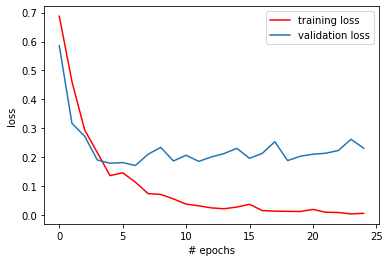

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

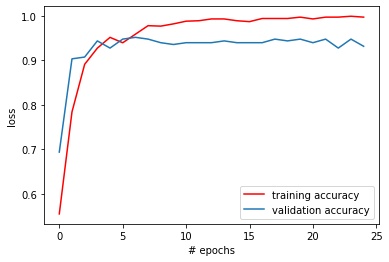

In [10]:

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
print(model.evaluate(test_data,test_target))

138/138 [==============================] - 4s 26ms/step
[0.1384562114118666, 0.9710144996643066]


In [13]:
model.save('TrainedFaceModel.h5')

## Part 3 Detect Faces with and without mask

In [14]:
from keras.models import load_model
import cv2
import numpy as np

In [15]:
model = load_model('model-007.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [16]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        
        break
        
cv2.destroyAllWindows()
source.release()

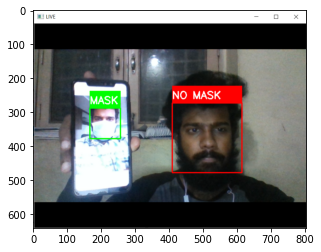

In [22]:
##Diplaying the captured image from the video

output_frame = cv2.imread('OpenCV/DATA/Mask_NoMask.PNG')
output_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
plt.imshow(output_frame)

## THANK YOU